In [1]:
import sys
sys.path.insert(0, "../src")

from UNet import *           
from trainer import *
from train import *

In [2]:
h5_path = "../data/processed/mama-mia_selected_slices.h5"

df = build_dataframe(str(h5_path))
print(f"Total slices: {len(df)}, Pos: {df['label'].sum()}, Neg: {len(df) - df['label'].sum()}")

# Train/Val/Test split
train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df['label'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df['label'], random_state=42
)

Total slices: 110753, Pos: 56884, Neg: 53869


In [3]:
batch_size = 32
ds_kwargs = dict(
    batch_size=batch_size,
    pin_memory=True,
    num_workers=8,
    persistent_workers=True,
    prefetch_factor=4
)

test_loader = DataLoader(
HDF5SliceDataset(str(h5_path), test_df), shuffle=False, **ds_kwargs
)

In [4]:
# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = Unet(input_channel=6).to(device)

# Load the saved state dict
checkpoint_path = "../data/models/best_model_epoch89_dice0.9031.pth"
state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()  # set to eval mode

# Define metric functions
def dice_coeff(probs, target, smooth=1e-6):
    probs = (probs > 0.5).float()            # binarize predictions
    p_flat = probs.view(probs.size(0), -1)
    t_flat = target.view(target.size(0), -1)
    inter = (p_flat * t_flat).sum(dim=1)
    union = p_flat.sum(dim=1) + t_flat.sum(dim=1)
    return ((2*inter + smooth)/(union + smooth)).mean().item()

def iou_score(probs, target, smooth=1e-6):
    probs = (probs > 0.5).float()
    inter = (probs * target).sum(dim=(1,2,3))
    union = ((probs + target) >= 1).float().sum(dim=(1,2,3))
    return ((inter + smooth)/(union + smooth)).mean().item()

# Run through test_loader
dice_total = 0.0
iou_total  = 0.0
n_batches  = 0

with torch.no_grad():
    for imgs, masks, _ in test_loader:
        imgs  = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = model(imgs)                 # [B,1,H,W]
        probs  = torch.sigmoid(logits)       # [B,1,H,W]

        dice_total += dice_coeff(probs, masks)
        iou_total  += iou_score(probs, masks)
        n_batches  += 1

avg_dice = dice_total / n_batches
avg_iou  = iou_total  / n_batches
print(f"Test set → Mean Dice: {avg_dice:.4f}, Mean IoU: {avg_iou:.4f}")

Test set → Mean Dice: 0.9068, Mean IoU: 0.8638


In [ ]:
import torch

metrics_path = "../data/models/metrics_dice_90.pth"

metrics = torch.load(metrics_path, map_location="cpu")

print("metrics uploaded:", metrics)

if isinstance(metrics, dict):
    print("\n–– metrics detail ––")
    for name, value in metrics.items():
        if torch.is_tensor(value):
            try:
                value = value.item()
            except RuntimeError:
                pass
        print(f"{name}: {value}")
else:
    print(metrics)


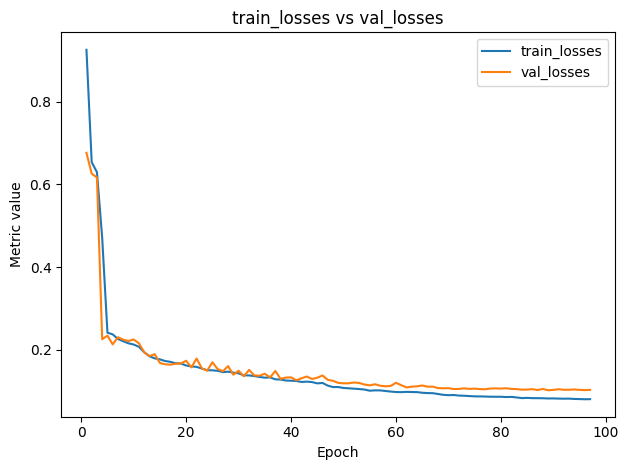

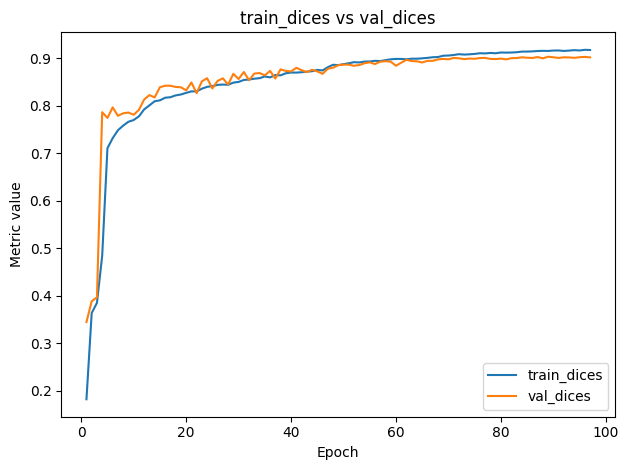

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Cleanup: convert tensors to Python lists or scalars
clean_metrics = {}
for k, v in metrics.items():
    if torch.is_tensor(v):
        try:
            arr = v.cpu().numpy()
            clean_metrics[k] = arr.tolist()
        except:
            clean_metrics[k] = v.item()
    else:
        clean_metrics[k] = v

# Extract sequence metrics (histories per epoch)
seq_metrics = {k: v for k, v in clean_metrics.items() if isinstance(v, list)}
if not seq_metrics:
    seq_metrics = {k: ([v] if not isinstance(v, list) else v)
                   for k, v in clean_metrics.items()}

# Create DataFrame
df = pd.DataFrame(seq_metrics)
df.index = df.index + 1
df.index.name = "Epoch"

# Plot only the first two metrics
cols = df.columns.tolist()
for i in range(0, len(cols), 2):
    pair = cols[i:i+2]
    if len(pair) < 2:
        break
    plt.figure()
    for col in pair:
        plt.plot(df.index, df[col], label=col)
    plt.title(f"{pair[0]} vs {pair[1]}")
    plt.xlabel("Epoch")
    plt.ylabel("Metric value")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
import random
import numpy as np


def load_model(path: str, device):
    """
    Loads a saved UNet model from a .pth file and sets it to evaluation mode.
    """
    model = Unet(input_channel=6).to(device)
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    return model


def visualize_random_samples(loader, device, checkpoint_path, n_samples=5):
    """
    Loads the saved model, selects n_samples random examples, and displays for each:
      • Original image with ground truth mask overlaid in red
      • Original image with prediction overlay in red
    """
    # Resolve dataset
    dataset = loader.dataset if isinstance(loader, DataLoader) else loader

    # Load model once
    model = load_model(checkpoint_path, device)
    indices = random.sample(range(len(dataset)), n_samples)

    for idx in indices:
        img, mask, _ = dataset[idx]
        img_batch = img.unsqueeze(0).to(device)
        with torch.no_grad():
            pred_logits = model(img_batch)
            pred_probs = torch.sigmoid(pred_logits)[0, 0]
        pred_mask = (pred_probs > 0.5).cpu().numpy().astype(float)

        # Prepare images
        img_np = img.cpu().numpy().mean(axis=0)  # mean across channels -> HxW
        gt_mask = mask.cpu().numpy()[0].astype(float)  # HxW

        # Create masked arrays for overlay (mask out zeros)
        masked_gt = np.ma.masked_where(gt_mask == 0, gt_mask)
        masked_pred = np.ma.masked_where(pred_mask == 0, pred_mask)

        # Plot two panels
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        # Panel 1: ground truth overlay
        axes[0].imshow(img_np, cmap='gray')
        axes[0].imshow(masked_gt, cmap='Reds', alpha=0.5, vmin=0, vmax=1)
        axes[0].set_title('Ground Truth Overlay')
        # Panel 2: prediction overlay
        axes[1].imshow(img_np, cmap='gray')
        axes[1].imshow(masked_pred, cmap='Reds', alpha=0.5, vmin=0, vmax=1)
        axes[1].set_title('Prediction Overlay')
        for ax in axes:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

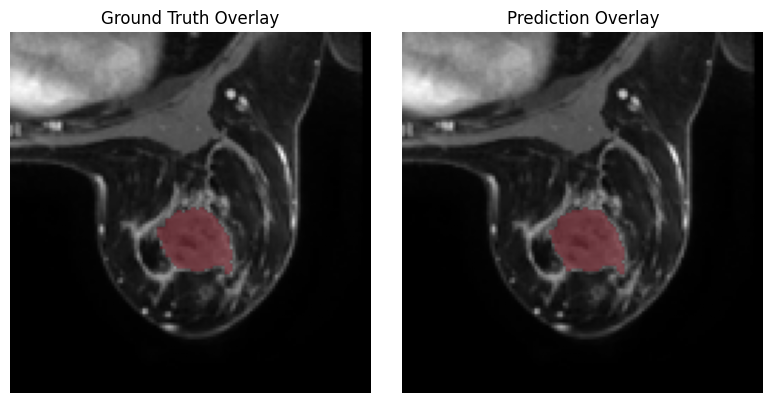

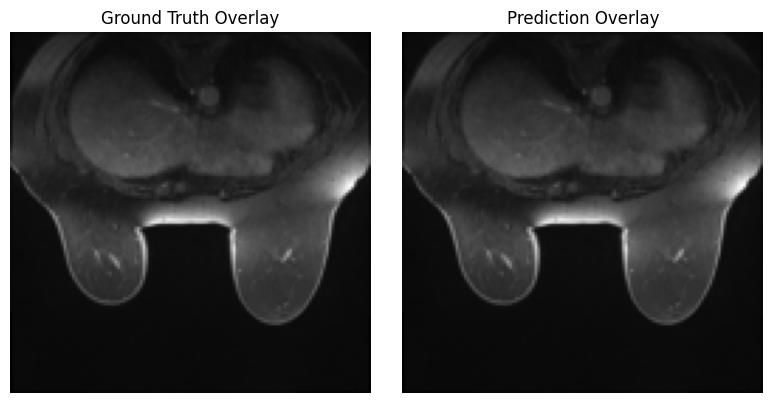

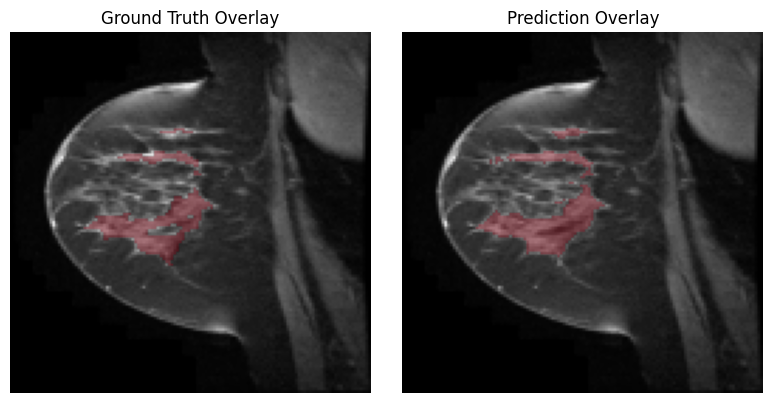

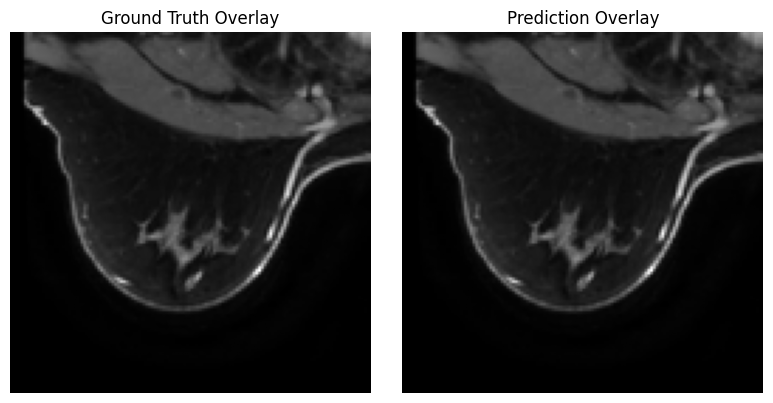

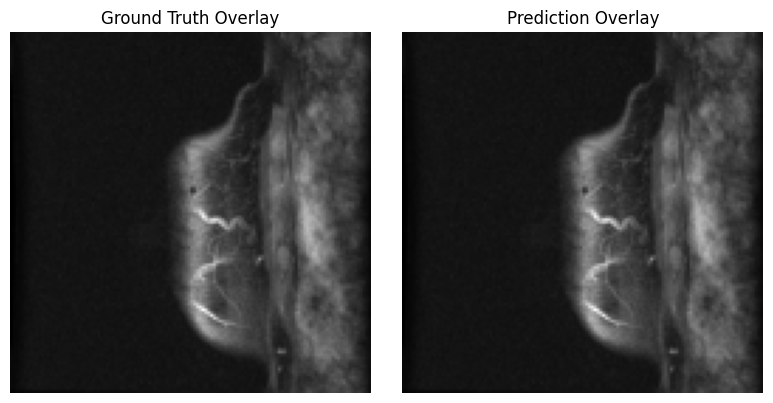

In [10]:
visualize_random_samples(test_loader, device, checkpoint_path, n_samples=5)

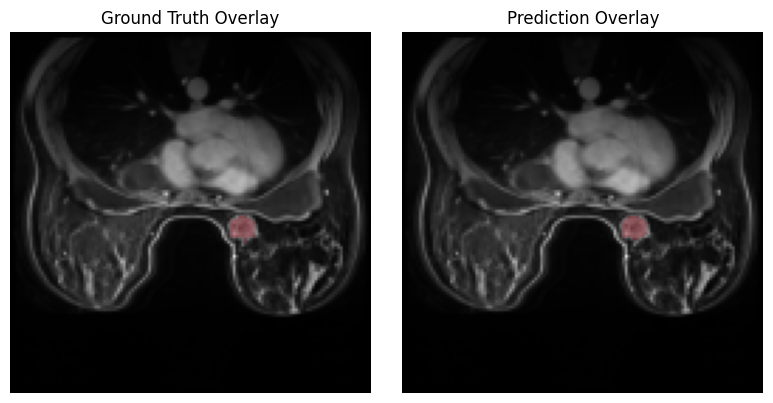

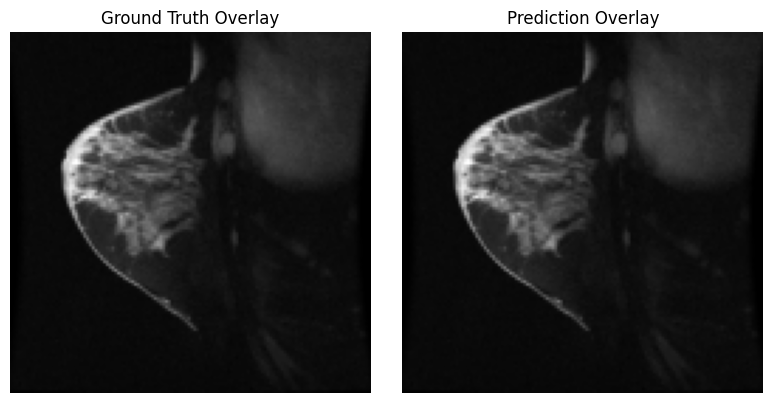

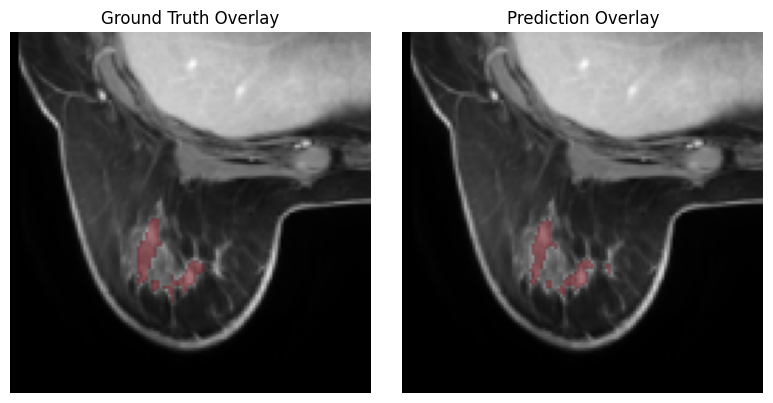

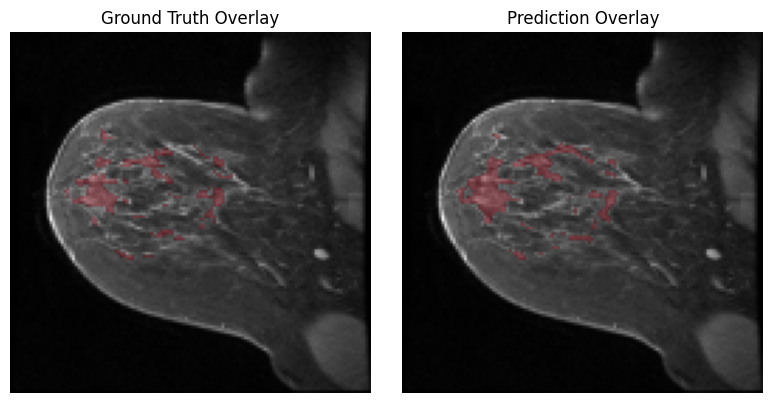

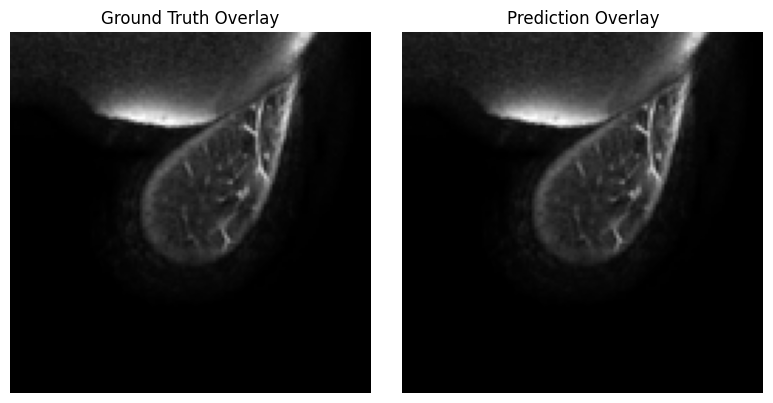

In [11]:
visualize_random_samples(test_loader, device, checkpoint_path, n_samples=5)

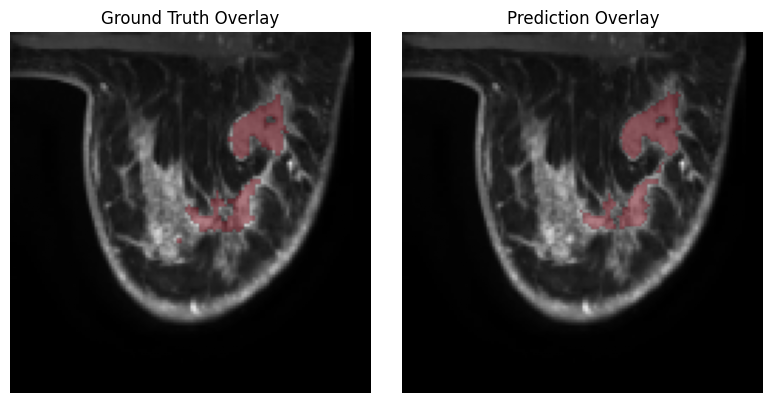

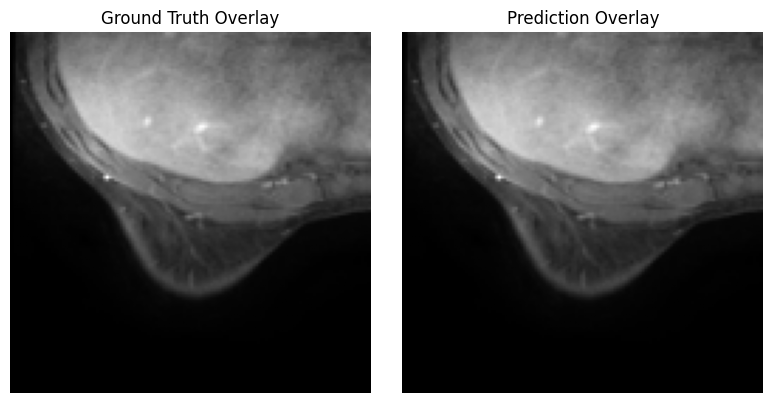

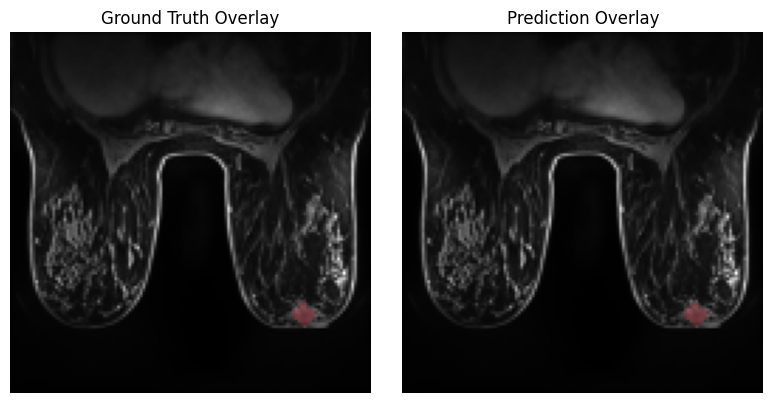

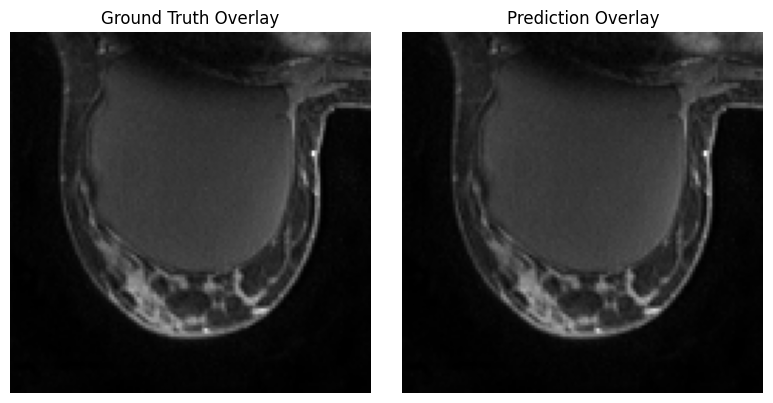

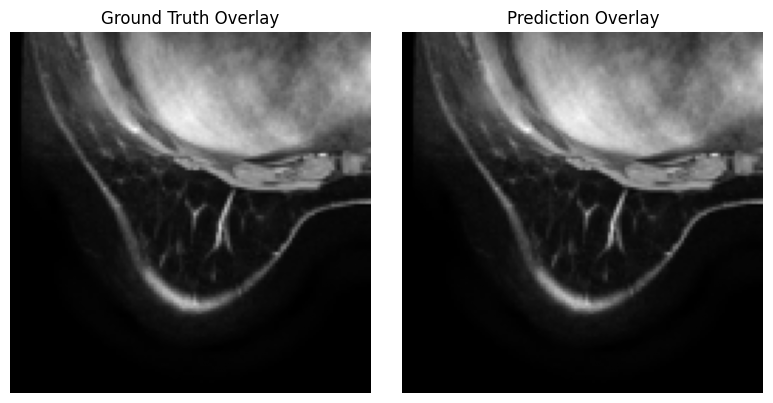

In [12]:
visualize_random_samples(test_loader, device, checkpoint_path, n_samples=5)

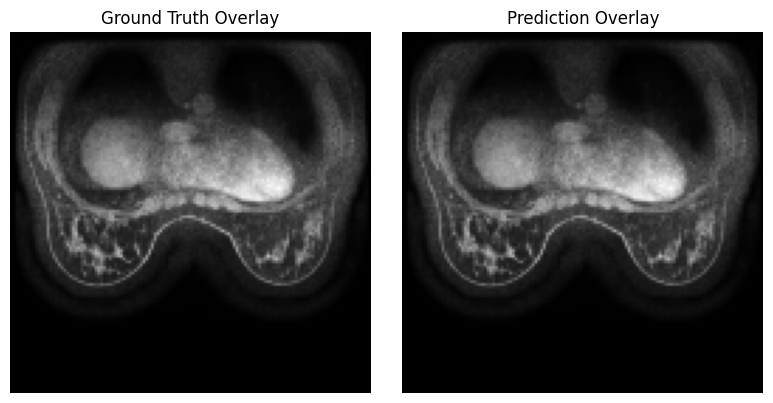

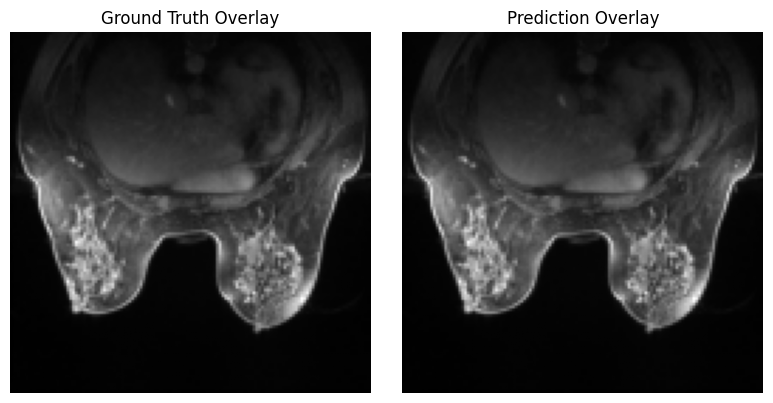

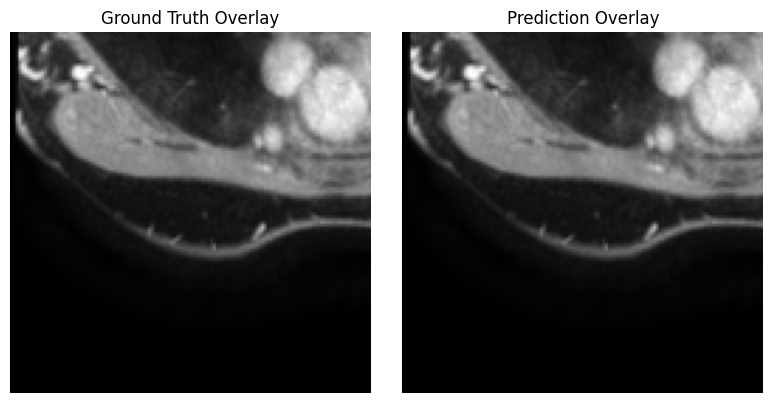

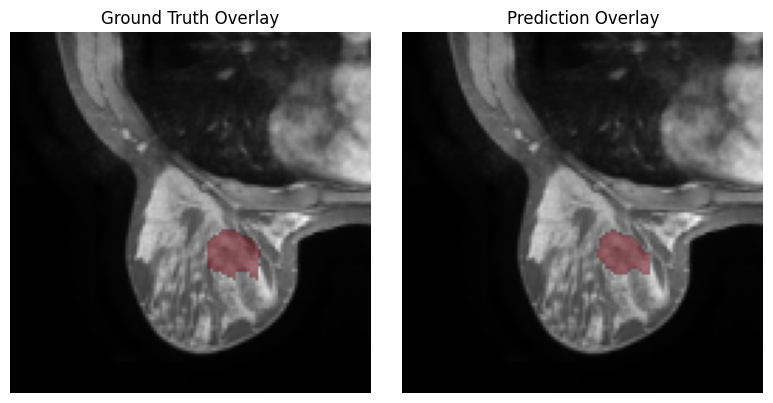

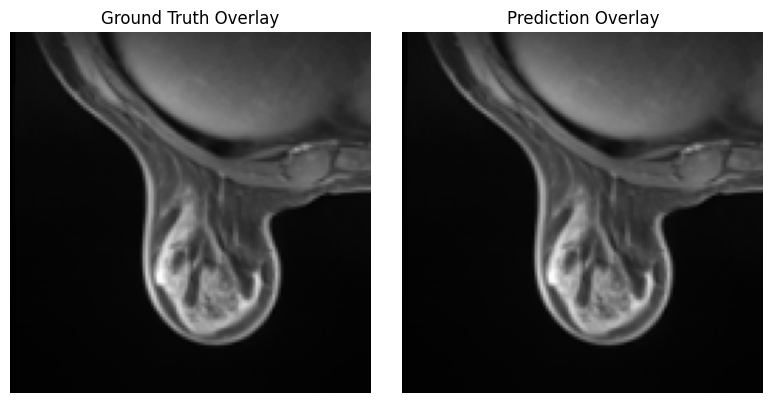

In [13]:
visualize_random_samples(test_loader, device, checkpoint_path, n_samples=5)